In [1]:
# basics
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE
# joblib
import joblib
# mlflow
import mlflow
# great expectations
import great_expectations as gx
# nannyml
import nannyml as nml
# termcolor
from termcolor import colored

# Load Data

In [2]:
dataframe = pd.read_csv('Data/smoke_detection.csv', index_col=[0])

# Split Data

In [3]:
def split_dataframe(dataframe: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # order dataframe by month
    dataframe = dataframe.sort_values(by='UTC').reset_index(drop=True)
    
    # split dataframe into 3 equal sized datasets
    dataframe_1 = dataframe.iloc[:int(len(dataframe)/3)]
    dataframe_2 = dataframe.iloc[int(len(dataframe)/3):int(len(dataframe)/3)*2]
    dataframe_3 = dataframe.iloc[int(len(dataframe)/3)*2:]
    
    return dataframe_1, dataframe_2, dataframe_3

In [4]:
# apply function
df1, df2, df3 = split_dataframe(dataframe)

# 1. Preprocessing

## 1.1 Train/Test Split

In [5]:
x, y = df1.drop(columns=['Fire Alarm']), df1['Fire Alarm']

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, stratify=y,random_state=420)

## 1.2 Preprocessing Function

In [7]:
def preprocessing(x: pd.DataFrame, y: pd.Series = None, reset=False) -> pd.DataFrame:

  # drop columns
  x = x.drop(columns=['UTC', 'CNT'])

  # apply outlier handling (IQR - floor and ceiling)
  for col in x.columns:
    q1, q3 = np.nanquantile(x[col], 0.25), np.nanquantile(x[col], 0.75)
    iqr = q3 - q1
    lower_bound, upper_bound = q1-(1.5*iqr), q3+(1.5*iqr)
    x[col] = [lower_bound if i < lower_bound else upper_bound if i > upper_bound else i for i in x[col]]

  # preprocessing pipeline
  global pipeline
  pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

  # fit & transform pipeline + SMOTE
  if reset:
    # apply preprocessing pipeline
    x = pipeline.fit_transform(x)
    # save the pipeline
    joblib.dump(pipeline, 'Pipeline/pipeline.pkl')
    # Smote
    smote = SMOTE(random_state=420)
    # fit smote
    x, y = smote.fit_resample(x, y)
    # print message
    print('Preprocessing Pipeline: Fit & Transform')
    # return x and y
    return x, y
  # transform pipeline
  else:
    # load pipeline
    pipeline = joblib.load('Pipeline/pipeline.pkl')
    # apply preprocessing pipeline
    x = pipeline.transform(x)
    # print message
    print('Preprocessing Pipeline: Transform')
    # return x
    return x

## 1.3 Apply Preprocessing to Train/Test Split

In [8]:
# preprocess training data
xtrain_prepro, ytrain_prepro = preprocessing(xtrain, ytrain, reset=True)

Preprocessing Pipeline: Fit & Transform


In [9]:
# preprocess test data
xtest_prepro = preprocessing(xtest)

Preprocessing Pipeline: Transform


# 2. Train Multiple Classifier

In [10]:
def classifier_comparison(
    xtrain: pd.DataFrame = xtrain_prepro,
    ytrain: pd.DataFrame = ytrain_prepro,
    xtest: pd.DataFrame = xtest_prepro,
    ytest: pd.DataFrame = ytest,
    clf: dict = {
        'Logistic Regression': LogisticRegression(random_state=420),
        'Decision Tree': DecisionTreeClassifier(random_state=420),
        'Random Forest': RandomForestClassifier(random_state=420)
        }
    ):

    # build plot
    fig, ax = plt.subplots(1, figsize=(10, 7))
    # iterate over classifiers
    for name, clf in clf.items():
        # fit classifier
        clf.fit(xtrain, ytrain)
        # plot roc curve
        RocCurveDisplay.from_estimator(clf, xtest, ytest, ax=ax, name=name)
    ax.set_title('Receiver Operating Characteristic (ROC)')
    ax.plot([0,1], [0,1], linestyle='--')
    # save plot
    plt.savefig('Plots/ROC Curves.png')
    # show plot
    plt.show()

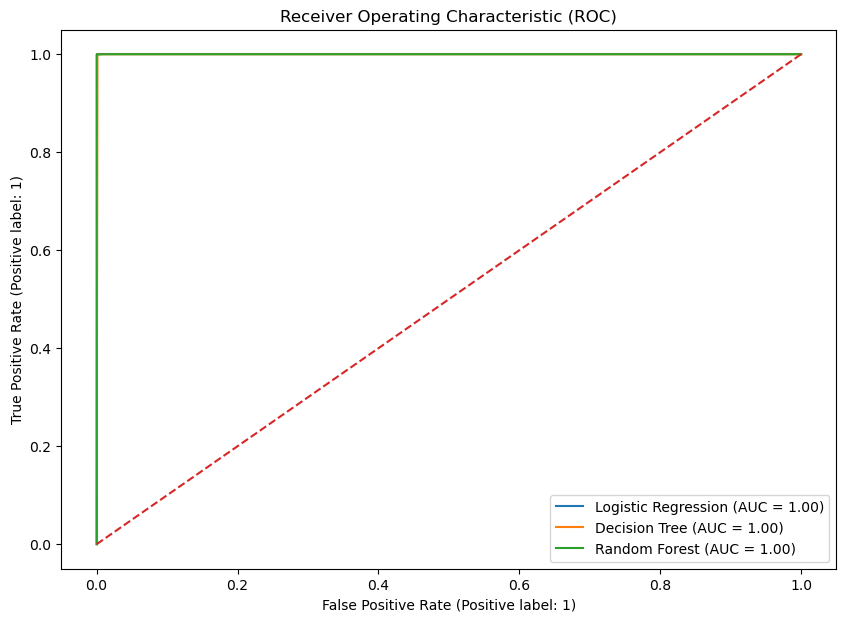

In [11]:
classifier_comparison(xtrain=xtrain_prepro, ytrain=ytrain_prepro, xtest=xtest_prepro, ytest=ytest)

# 3. Feature Importance

In [12]:
# function to calculate feature importance for random forest inputs (x, y and clf)
def feature_importance(
    clf,
    x: pd.DataFrame = xtrain_prepro,
    y: pd.DataFrame = ytrain_prepro,
    columns: list = xtrain.columns.drop(['CNT', 'UTC']),
    ):

    # fit classifier
    clf.fit(x, y)
    # create dataframe with feature names and feature importance
    df = pd.DataFrame({'Feature': columns, 'Importance': clf.feature_importances_})
    # sort dataframe by feature importance
    df = df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    # plot feature importance
    fig, ax = plt.subplots(1, figsize=(10, 7))
    sns.barplot(x='Importance', y='Feature', data=df, ax=ax)
    ax.set_title('Feature Importance')
    # save plot
    plt.savefig('Plots/Feature Importance.png')
    # show plot
    plt.show()

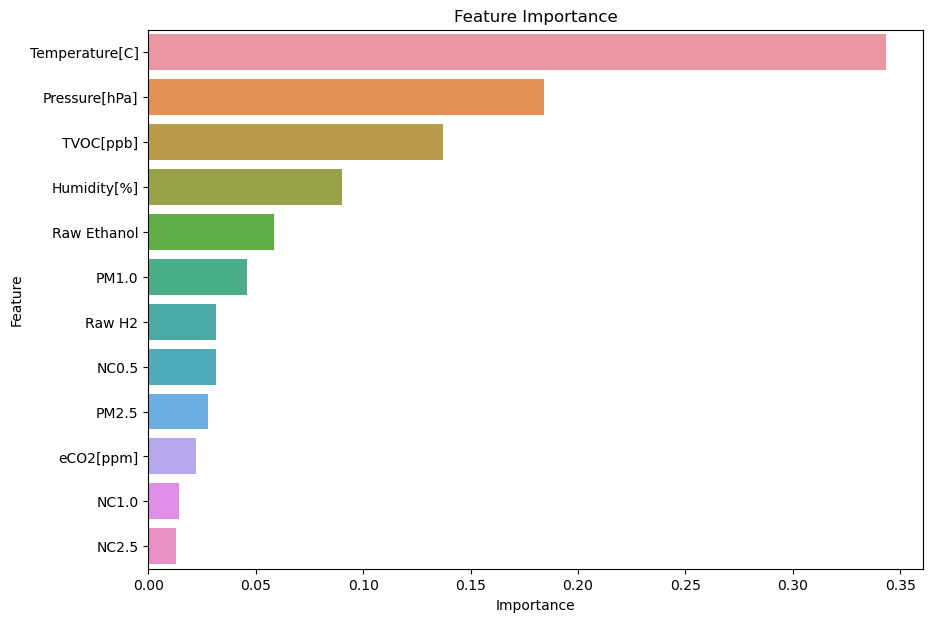

In [13]:
feature_importance(RandomForestClassifier(random_state=420), xtrain_prepro, ytrain_prepro)

# 4. Grid Search

## 4.1 Grid Search Function

In [14]:
# def grid_search(
#     x: pd.DataFrame,
#     y: pd.DataFrame,
#     param_grid: dict,
#     clf = RandomForestClassifier(random_state=420)
#     ):
    
#     grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
#     # fit grid search
#     grid_search.fit(x, y)
#     # return grid search
#     return grid_search

# 5. Train Model with Grid Search

## 5.1 Fit Model Function

In [15]:
def training(
        x: pd.DataFrame,
        y: pd.DataFrame,
        param_grid: dict,
        clf = RandomForestClassifier(random_state=420)
        ):
    
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', n_jobs=-1)
    # fit grid search
    grid_search.fit(x, y)
    # return model
    return grid_search

## 5.2 Combine Train/Test Data

In [16]:
# combine train and test data
x_train, y_train = df1.drop(columns=['Fire Alarm']), df1['Fire Alarm']

x_train, y_train = preprocessing(x=x_train, y=y_train, reset=True)

Preprocessing Pipeline: Fit & Transform


## 5.3 Fit Model on Train Data

In [17]:
# Train Random Forest with Grid Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
    }

rf = training(x=x_train, y=y_train, param_grid=param_grid, clf=RandomForestClassifier(random_state=420))

# 6. Make Predictions

## 6.1 Predict Data Function

In [18]:
def predict_data(
        x: pd.DataFrame,
        y: pd.DataFrame,
        clf
        ):
    
    # predict_proba
    ypred_proba = clf.predict_proba(x)
    # ypred
    ypred = np.argmax(ypred_proba, axis=1)
    # return ypred_proba and ypred
    return ypred_proba, ypred

# 7. Dataframe 2

## 7.1 Prepare Dataframe 2

In [19]:
df2_prepro, df2_y = preprocessing(df2.drop(columns=['Fire Alarm'])), df2['Fire Alarm']

Preprocessing Pipeline: Transform


## 7.2 Predict Dataframe 2

In [20]:
ypred_proba, ypred = predict_data(x=df2_prepro, y=df2_y, clf=rf)

In [21]:
print(classification_report(df2_y, ypred))

              precision    recall  f1-score   support

           0       0.44      1.00      0.61      3178
           1       1.00      0.77      0.87     17698

    accuracy                           0.80     20876
   macro avg       0.72      0.88      0.74     20876
weighted avg       0.91      0.80      0.83     20876



# 8. Retrain Model

## 8.1 Combine Dataframe 1 & Dataframe 2

In [22]:
combined = pd.concat([df1, df2], axis=0)

x_combined, y_combined = combined.drop(columns=['Fire Alarm']), combined['Fire Alarm']

## 8.2 Preprocess Combined Data

In [23]:
x_retrain, y_retrain = preprocessing(x=x_combined, y=y_combined, reset=True)

Preprocessing Pipeline: Fit & Transform


## 8.3 Fit on Combined Data

In [24]:
# Train Random Forest with Grid Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10]
    }

rf_retrain = training(x=x_retrain, y=y_retrain, param_grid=param_grid, clf=RandomForestClassifier(random_state=420))

# 9. Dataset 3

## 9.1 Prepare Dataframe 3

In [25]:
df3_prepro, df3_y = preprocessing(df3.drop(columns=['Fire Alarm'])), df3['Fire Alarm']

Preprocessing Pipeline: Transform


## 9.2 Predict Dataframe 3

In [26]:
ypred_proba, ypred = predict_data(x=df3_prepro, y=df3_y, clf=rf_retrain)

In [27]:
print(classification_report(df3_y, ypred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      5775
           1       1.00      0.93      0.96     15103

    accuracy                           0.95     20878
   macro avg       0.92      0.96      0.94     20878
weighted avg       0.96      0.95      0.95     20878

